In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import r2_score

np.random.seed(1)

import warnings
warnings.filterwarnings('ignore')

In [2]:
daily_weather = pd.read_csv('merge_in/near_weather_all_days.csv')
grid_char = pd.read_csv('merge_in/TCN_DATA USE.csv')

# Question 1: Predicting Outages per Day

## Preprocessing data

**Importing df**

In [3]:
# # Look at dfs
# DF1_outages_p_day.head(5)
# daily_weather.head(5)
# grid_char.head(5)

# #Check data types of date columns
# type(DF1_outages_p_day['date'][0]), type(daily_weather['date'][0]), type(grid_char['Date'][0])

In [4]:
# Read in cleaned outage dfs
DF1_outages_p_day = pd.read_csv('model_dfs/DF1_outages_p_day.csv')

# Update DF1_outages_p_day
pd.set_option('display.max_columns', 100)
DF1_outages_p_day = DF1_outages_p_day.rename(columns = {'Unnamed: 0':'date'})

# Merge w/ daily weather data
DF1_outages_p_day = pd.merge(DF1_outages_p_day, daily_weather, how = 'left', 
                             left_on = ['date'], right_on = ['date'])

# Merge w/ grid/power system data
grid_char = grid_char.drop(columns = ['Unnamed: 0'])
DF1_outages_p_day = pd.merge(DF1_outages_p_day, grid_char, how = 'left', 
                             left_on = ['date'], right_on = ['Date'])

DF1_outages_p_day = DF1_outages_p_day.drop(columns = ['Date'])

# Drop rows with null values
DF1_outages_p_day = DF1_outages_p_day.dropna().reset_index(drop=True)

DF1_outages_p_day

,date,outage_tot,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mon,tues,wed,thurs,fri,sat,sun,atmosphericpressure (kPa),precipitation (mm),radiation (W/m2),relativehumidity (-),temperature (degrees Celsius),winddirection (degrees),windgusts (m/s),windspeed (m/s),Peak Generation (MW),Lowest Generation (MW),Energy Recorded(Mwh),Generation at 6:00hrs (MW),Highest System Frequency (Hz),Lowest System Frequency (Hz),Highest Voltage Recorded (kV),Lowest Voltage Recorded (kV)
0,2020-01-01,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,98.956667,0.000000,205.750000,0.504167,23.741667,137.166667,1.616667,0.796250,4676.8,3399.3,94460.20,3617.5,50.660,49.750,350.0,300.0
1,2020-01-02,79.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,99.063333,0.000000,202.958333,0.341667,24.741667,81.416667,3.095000,1.534167,4549.0,2828.7,85272.73,3056.6,50.766,49.928,356.0,300.0
2,2020-01-03,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,99.142917,0.000000,209.791667,0.340417,23.425000,73.833333,3.047083,1.472083,4406.8,2461.1,81366.23,2942.9,50.959,49.903,357.0,300.0
3,2020-01-04,65.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,99.139583,0.000000,187.000000,0.353333,23.754167,45.583333,2.591667,1.272083,4396.5,2679.1,81999.20,3026.7,50.820,49.810,355.0,300.0
4,2020-01-05,64.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,99.031667,0.000000,165.291667,0.435000,24.070833,122.208333,1.596667,0.817500,4697.7,2591.6,83782.87,3064.3,50.910,49.870,355.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2020-12-27,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,98.826667,0.000000,165.166667,0.604542,25.054167,285.208333,1.119583,0.872083,5041.9,3803.1,105146.53,4527.9,50.397,49.340,353.0,300.0
344,2020-12-28,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,98.862917,0.000000,142.333333,0.602583,25.187500,289.666667,1.081250,0.825833,4895.9,3686.1,106600.58,4119.6,50.299,49.452,351.0,300.0
345,2020-12-29,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,98.825417,0.000000,147.625000,0.581667,25.979167,295.000000,1.056667,0.782083,4920.5,3975.1,108168.69,4365.8,50.300,49.440,353.0,300.0
346,2020-12-30,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,98.896250,0.000000,139.958333,0.653167,26.029167,298.750000,1.156667,0.874167,4920.8,3814.5,107440.11,4143.5,50.370,49.446,352.0,300.0


In [5]:
# Check for null values
#DF1_outages_p_day.isnull().values.any(), DF1_outages_p_day.isnull().sum()

**Standardize & split data into train & test**

In [6]:
def get_Xy(df, cols_to_drop, y_col, test_size, random_state):
    """
    This function returns four dataframes containing the testing and training X and y values used in regression.
    Input: df, a Pandas dataframe with all of the fields in the regression dataset; 
        cols_to_drop, a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        y_col, a column name (as a string) of df that represents the response variable
        test_size, a float between 0 and 1 indicating the fraction of the data to include in the test split
        random_state, an integer, used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # Replace the ellipses with your code
    X = df.drop(columns=cols_to_drop) # The X dataframe should be a subset of df; make sure to drop the columns in the cols_to_drop list
    y = df[[y_col]] # The column of df containing the response variable
    
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(X, y) 
    X_stnd = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size = test_size,
                                                        random_state = random_state)
    
    return X_train, X_test, y_train, y_test

In [7]:
df = DF1_outages_p_day
cols_to_drop = ['date', 'outage_tot']
y_col = 'outage_tot'
test_size = 0.2
random_state = 2021
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = get_Xy(df, cols_to_drop, y_col, test_size, random_state)

## Model 1: OLS

In [8]:
lm = LinearRegression()
lm.fit(X_train_m1, y_train_m1)
y_pred = lm.predict(X_test_m1)

mse = mean_squared_error(y_test_m1, y_pred)
r2 = r2_score(y_test_m1, y_pred)
print('Test MSE: ', mse)
print('R squared: ', r2)

Test MSE:  191.04489196273926
R squared:  -0.020890646325725237


In [9]:
# We initially wrote this code in order to see how it performed with different data subsets
# and look at variation in MSE across samples

# # Run kfold cv for OLS model to get mean validation MSE across folds
# # Compare this MSE against validation MSE of other models

# kf = KFold(n_splits = 20, shuffle = True, random_state = 2021)

# fold_mse = [] # initiate a list to hold the MSE associated with each fold

# X = X_train_m1
# y = np.array(y_train_m1)

# for t_index, v_index in kf.split(X):

#     # Subset X and y into training and validation subsets
#     X_fold_train = X[t_index]
#     y_fold_train = y[t_index]
#     X_fold_val = X[v_index]
#     y_fold_val = y[v_index]

#     # Initiate and fit a linear regression model using the training data
#     lm = LinearRegression()
#     lm.fit(X_fold_train, y_fold_train)

#     # Predict the Y-values associated with the validation data
#     y_pred = lm.predict(X_fold_val)

#     # Find the testing MSE and append it to fold_mse
#     mse_f = mean_squared_error(y_fold_val, y_pred)
#     fold_mse.append(mse_f)


# print(fold_mse)

# # Find the mean MSE across all four folds
# print('Mean validation MSE = ' + str(np.mean(fold_mse)))

# print('Min validation MSE = ' + str(np.min(fold_mse)))

## Models 2 & 3: Ridge & Lasso

**Use cross-validation to select alpha value** 

In [10]:
def model_cv_mse(SKL_model, X, y, alphas, k = 5, random_state = 2021):
    """
    This function calculates the MSE resulting from k-fold CV using Lasso or Ridge regression performed on a training subset of 
    X and y for different values of alpha.
    Inputs: 
        SKL_model (sklearn model): the type of sklearn model with which to fit the data - options include Ridge, or Lasso
        X: the set of features used to fit the model
        y: the set of response variable observations
        alphas: a list of penalty parameters
        k: number of folds in k-fold cross-validation
        random_state: a random seed to use in KFold
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    mses = np.full((k,len(alphas)),np.nan) # initialize array of null values. Each row should represent one of the k folds. Each column should represent a value of alpha.
        
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state) # get kfold split
    
    fold = 0
    for train_i, val_i in kf.split(X): # loop through k folds
        # get the training and validation data for each fold
        X_f_train = X[train_i]
        X_f_val = X[val_i]
        y_f_train = y.iloc[train_i]
        y_f_val = y.iloc[val_i]
        
        for i in range(len(alphas)): # loop through each value of alpha
            model = SKL_model(alpha = alphas[i]) # initialize model

            model.fit(X_f_train, y_f_train) # fit model
            
            y_pred = model.predict(X_f_val) # get predictions on the validation data
            
            # save the MSE for this fold and alpha value
            mses[fold,i] = mean_squared_error(y_pred, y_f_val)
        
        fold += 1 # move on to the next fold
    
    average_mses = np.mean(mses, axis = 0) # get the average MSE for each alpha value across all folds
    
    return average_mses

In [11]:
# Commented out b/c takes a fair amount of time to run
# # Plot MSE by alpha value to search for optimal alpha value
# # Run CV & plot CV MSE
# alphas_ridge = [50, 70, 90, 100, 110, 150] # create an array or list of alpha values to test in Ridge regression
# alphas_lasso = [0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5] # create an array or list of alpha values to test in Lasso regression

# plt.figure(figsize = (20,10))

# # Plot the cross-validated MSE versus alpha for ridge
# plt.subplot(121)
# ridge_mses = model_cv_mse(Ridge, X_train_m1, y_train_m1, alphas_ridge, k=10)
# plt.plot(alphas_ridge, ridge_mses)
# plt.title('Ridge regression cross-validated MSE versus alpha')
# plt.xlabel('alpha value')
# plt.ylabel('MSE')

# # Plot the cross-validated MSE versus alpha for Lasso
# plt.subplot(122)
# lasso_mses = model_cv_mse(Lasso, X_train_m1, y_train_m1, alphas_lasso, k=10)
# plt.plot(alphas_lasso, lasso_mses)
# plt.title('Lasso regression cross-validated MSE versus alpha')
# plt.xlabel('alpha value')
# plt.ylabel('MSE')

# plt.show()

In [12]:
from sklearn.linear_model import RidgeCV

alphas_ridge = [0, 0.1, 1, 10, 100, 1000] # create an array or list of alpha values to test in Ridge regression
alphas_lasso = [0, 0.1, 1, 10, 100, 1000] # create an array or list of alpha values to test in Lasso regression
# alphas_ridge = [70, 90, 100, 110, 150] # create an array or list of alpha values to test in Ridge regression
# alphas_lasso = [0.9, 1, 1.1, 1.2, 1.3] # create an array or list of alpha values to test in Lasso regression

kf = KFold(n_splits = 5, shuffle = True, random_state = 2021) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=alphas_ridge) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_train_m1, y_train_m1) # fit RidgeCV model on training data

ridge_alpha_opt = ridgecv.alpha_ # get optimal alpha value
print("optimal alpha:", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_test_m1) # get test predictions using RidgeCV model

ridge_cv_mse = mean_squared_error(y_pred_ridgecv, y_test_m1) # get MSE of RidgeCV model
ridge_r2 = r2_score(y_test_m1, y_pred_ridgecv)
print("Test MSE with cross-validated Ridge:", ridge_cv_mse)
print("Ridge R squared with cross-validated Ridge:", ridge_r2)

optimal alpha: 100.0
Test MSE with cross-validated Ridge: 175.25647410163438
Ridge R squared with cross-validated Ridge: 0.06347825749101554


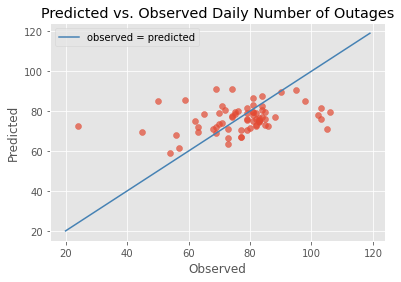

In [13]:
plt.scatter(y_test_m1, y_pred_ridgecv, alpha = 0.7)
x = np.arange(20, 120)
plt.plot(x, x, label = 'observed = predicted', color = 'steelblue')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Predicted vs. Observed Daily Number of Outages')
plt.legend()
plt.show()

In [14]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas=alphas_lasso) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_train_m1, y_train_m1) # fit RidgeCV model on training data

lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
print("optimal alpha:", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_test_m1) # get test predictions using RidgeCV model

lasso_cv_mse = mean_squared_error(y_pred_lassocv, y_test_m1) # get MSE of LassoCV model
lasso_r2 = r2_score(y_test_m1, y_pred_lassocv)

print("Test MSE with cross-validated Lasso:", lasso_cv_mse)
print("Ridge R squared with cross-validated Lasso:", lasso_r2)

optimal alpha: 1.0
Test MSE with cross-validated Lasso: 185.33538886873416
Ridge R squared with cross-validated Lasso: 0.009619346608157664


## Model 4: Random Forest

In [15]:
df = DF1_outages_p_day
cols_to_drop = ['date', 'outage_tot']
X = df.drop(columns = cols_to_drop)
Y_obs = df['outage_tot']
test_size = 0.2
random_state = 2021

X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X, Y_obs, test_size=0.2, random_state=2021)

In [16]:
# use randomized search to find optimal model parameters


rf_tree = RandomForestRegressor(random_state = 2021, n_estimators = 100)

param_dist = {'min_samples_split': randint(3, 20),
              'max_depth': randint(2, 25)} # specify a dictionary with two parameters and the range of calues over which you'd like to choose values

rnd_rf_search = RandomizedSearchCV(rf_tree, param_distributions = param_dist, 
                                   cv=5, n_iter=10, random_state = 2021)

rnd_rf_search.fit(X_train_m1, y_train_m1)

print(rnd_rf_search.best_params_)
print(rnd_rf_search.best_score_)

{'max_depth': 3, 'min_samples_split': 8}
-0.011890611309127141


In [17]:
# Fit model based on optimal parameters
rf_tree.set_params(max_depth=3, min_samples_split=8)
rf_tree.fit(X_train_m1, y_train_m1)

tuned_train_score = rf_tree.score(X_train_m1, y_train_m1)
tuned_val_score = rf_tree.score(X_test_m1, y_test_m1)

print('Train Score: ', tuned_train_score)
print('Test Score: ', tuned_val_score)

Train Score:  0.29573048487534526
Test Score:  0.036029645320912684


In [18]:
# Getting MSE

from sklearn import metrics

y_pred_m1 = rf_tree.predict(X_test_m1)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_m1, y_pred_m1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_m1, y_pred_m1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_m1, y_pred_m1)))
print('R squared:', r2_score(y_test_m1, y_pred_m1))

Mean Absolute Error: 9.211113320260598
Mean Squared Error: 180.39308414448055
Root Mean Squared Error: 13.43104925701937
R squared: 0.036029645320912684


In [19]:
def importance_plot(tree):
    # YOUR CODE HERE
    feature_importance = tree.feature_importances_ # get the importance of each feature
    
    #calculate the relative feature importances 
    relative_importance = feature_importance/np.max(feature_importance)
    
    # Save to a dataframe with two columns: One holding the names of the features, 
    # and one holding the associated relative importance of each feature.
    feat_df = pd.DataFrame({'feature':X_train_m1.columns, 'importance':feature_importance})
    
    # Sort feat_df in order of importance
    feat_df = feat_df.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(8, 7.5))
    
    # Create a bar chart. The widths of the bars should correspond to the importances, 
    # and y should correspond to the names of the features. 
    plt.barh(width=feat_df['importance'], y=feat_df['feature'])
    plt.xlabel('Relative feature importance');

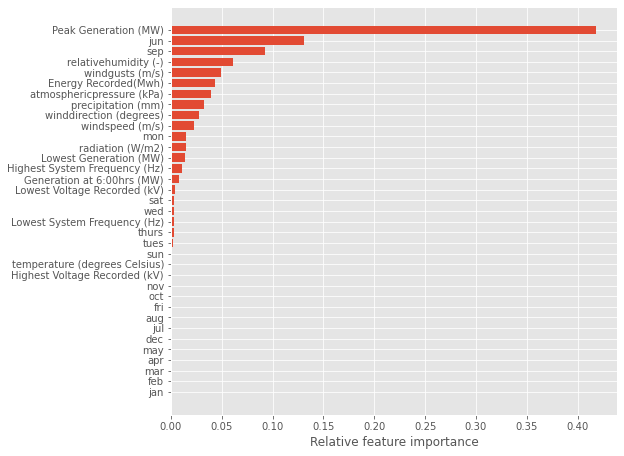

In [20]:
importance_plot(rf_tree)

# Question 2: Predicting Outage Duration

## Pre-process data

In [21]:
# Read in DF2
DF2_outage_duration = pd.read_csv('model_dfs/DF2_outage_duration.csv')

# Drop unnamed index column
DF2_outage_duration = DF2_outage_duration.drop(columns = ['Unnamed: 0'])
DF2_outage_duration.head(5)

,TARGET_Duration_Hours,date_dt NOT A FEATURE,Load Loss (MW),Event No,distances_trs,distances_pp,socioeconomic_vulnerability,LGA,EDE,ILE-IFE,Ikirun,Ilesa,Osogbo,11KV,33KV,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mon,tues,wed,thurs,fri,sat,sun,hr0,hr1,hr2,hr3,hr4,hr5,hr6,hr7,hr8,hr9,hr10,hr11,hr12,hr13,hr14,hr15,...,mokuro,mountcarmel,ncc,nmt,oau,oauthc,obelawo,odeomu,odoori,okeogbun,okuku_eleven,okuku_thirtythree,oluode,omiasoro,opa,orileowu,orona,oronaitaosa,osogbo,osogboikirun,palace,parakin,powerline,prism,rabsih,sekona,sekonaikirewasinmi,srm,wonderful,0,1,1&2,1&6,10,1B,1D,1F,1G,2,2&6,3,42,4B,5,6,7,7B,8,9,B/C
0,0.650000,2020-01-01,26150.0,1.0,5.198841,58.955655,1.106082,OSOGBO,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.116667,2020-01-01,26150.0,2.0,5.198841,58.955655,1.106082,OSOGBO,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.983333,2020-01-01,3209.0,1.0,12.543236,97.612181,2.582989,OBOKUN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.983333,2020-01-01,3209.0,1.0,12.543236,97.612181,2.582989,OBOKUN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.700000,2020-01-01,4000.0,1.0,10.256396,73.200909,2.025498,OROLU,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Merge w/ daily weather data
DF2_outage_duration = pd.merge(DF2_outage_duration, daily_weather, how = 'left', 
                             left_on = ['date_dt NOT A FEATURE'], right_on = ['date'])

# Merge w/ grid/power system data
DF2_outage_duration = pd.merge(DF2_outage_duration, grid_char, how = 'left', 
                             left_on = ['date_dt NOT A FEATURE'], right_on = ['Date'])

# OHE LGA
DF2_outage_duration = DF2_outage_duration.join(pd.get_dummies(DF2_outage_duration['LGA']))

# Drop irrelevant columns
DF2_outage_duration = DF2_outage_duration.drop(columns = ['date', 'Date', 'LGA'])
pd.set_option('display.max_columns', 300)

# Drop rows with null values
DF2_outage_duration = DF2_outage_duration.dropna().reset_index(drop=True)

DF2_outage_duration

,TARGET_Duration_Hours,date_dt NOT A FEATURE,Load Loss (MW),Event No,distances_trs,distances_pp,socioeconomic_vulnerability,EDE,ILE-IFE,Ikirun,Ilesa,Osogbo,11KV,33KV,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mon,tues,wed,thurs,fri,sat,sun,hr0,hr1,hr2,hr3,hr4,hr5,hr6,hr7,hr8,hr9,hr10,hr11,hr12,hr13,hr14,hr15,hr16,hr17,hr18,hr19,hr20,hr21,hr22,hr23,1a,1a&1e,1a&4a,1b,1b&1h,1b&2a,1c,1c&1d,1d,1d&1a,1d&1e,1d&1h,1d&1i,1d&2a,1d&3a,1d&3b,1d&4a,1d&4b,1e,1e&4b,1f,1g,1g&1c,1h,1h&1i,1h&1j,1h&2a,1h&4a,1h&99,1i,1i&1j,1i&2a,1i&3c,1i&4b,1j,1l,2a,2a&1a,2a&4b,2a&5a,2a&99,2b,2d,2s,3a,3b,3c,4a,4b,5a,5b,5c,6&1,6b,6c,7a,7b,e&f,edce&f,ef&oc,i,i&po,o&c,unknown,BC,BF,EDCBC,EDCEF,EDCEFOC,EDCEO,EDCFO,EDCIEFOC,EDCINSTOC,EDCLS,EDCMO,EDCNR,EDCNRI,EDCOC,EDCPO,EDECEF,EF,EFOC,FC,FO,GENSC,GENSYSCOLL,IEF,IFO,ILS,IOC,IPO,LLS,LS,NR,OC,PO,SC,TCNBO,TCNEF,TCNFC,TCNFO,TCNLS,TCNMO,TCNPO,TCNSC,TLS,TPO,akeju,apomu,ayepe,bowen,brewery,cottage,dadaestateprime,ede,edewaterworks,edunabonipetumodu,efonosu,ejigbo,famia,gbongan_i,gbongan_o,graosogbo,ibadan,ibokun,ifeodan,igbaye,igbona,ijebujesa,ikire,ikireapomu,ikirewasinmi,ikirun,ila,ilaje,ileife,ilesa,ipetu,ipetuijebu,ipetuijebujesa,ipetuile,ipetujesa,iretiayo,irogbo,ironandsteel,isare,itamerin,itaosa,iwo,iwoejigbo,iwoye,lagere,mokuro,mountcarmel,ncc,nmt,oau,oauthc,obelawo,odeomu,odoori,okeogbun,okuku_eleven,okuku_thirtythree,oluode,omiasoro,opa,orileowu,orona,oronaitaosa,osogbo,osogboikirun,palace,parakin,powerline,prism,rabsih,sekona,sekonaikirewasinmi,srm,wonderful,0,1,1&2,1&6,10,1B,1D,1F,1G,2,2&6,3,42,4B,5,6,7,7B,8,9,B/C,atmosphericpressure (kPa),precipitation (mm),radiation (W/m2),relativehumidity (-),temperature (degrees Celsius),winddirection (degrees),windgusts (m/s),windspeed (m/s),Peak Generation (MW),Lowest Generation (MW),Energy Recorded(Mwh),Generation at 6:00hrs (MW),Highest System Frequency (Hz),Lowest System Frequency (Hz),Highest Voltage Recorded (kV),Lowest Voltage Recorded (kV),ATAKUNMOSAWEST,AYEDADE,EDENORTH,EDESOUTH,EJIGBO,IFECENTRAL,IFEEAST,IFELODUN,IFENORTH,ILA,ILESHAEAST,ILESHAWEST,IREWOLE,ISOKAN,IWO,OBOKUN,ODOOTIN,OLORUNDA,ORIADE,OROLU,OSOGBO
0,0.650000,2020-01-01,26150.0,1.0,5.198841,58.955655,1.106082,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.956667,0.000000,205.750000,0.504167,23.741667,137.166667,1.616667,0.796250,4676.8,3399.30,94460.20,3617.5,50.660,49.75,350.0,300.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.116667,2020-01-01,26150.0,2.0,5.198841,58.955655,1.106082,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [23]:
# Check for null values
#DF2_outage_duration.isnull().values.any(), DF2_outage_duration.isnull().sum()

In [24]:
# DF2_outage_duration.to_csv('model_dfs/DF2_outage_duration_merged.csv')
# DF1_outages_p_day.to_csv('model_dfs/DF1_outages_p_day_merged.csv')

**Standardize & split data into train & test**

In [25]:
df = DF2_outage_duration
cols_to_drop = ['TARGET_Duration_Hours', 'date_dt NOT A FEATURE']
y_col = 'TARGET_Duration_Hours'
test_size = 0.2
random_state = 2021
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = get_Xy(df, cols_to_drop, y_col, test_size, random_state)

## Model 1: OLS

In [26]:
lm = LinearRegression()
lm.fit(X_train_m2, y_train_m2)
y_pred = lm.predict(X_test_m2)

mse = mean_squared_error(y_test_m2, y_pred)
r2 = r2_score(y_test_m2, y_pred)
print('Test MSE: ', mse)
print('R squared: ', r2)

Test MSE:  3.49205561736535e+27
R squared:  -2.249907219755688e+26


In [27]:
# We initially wrote this code in order to see how it performed with different data subsets
# and look at variation in MSE across samples

# # Run kfold cv for OLS model to get mean validation MSE across folds
# # Compare this MSE against validation MSE of other models

# kf = KFold(n_splits = 20, shuffle = True, random_state = 2021)

# fold_mse = [] # initiate a list to hold the MSE associated with each fold

# X = X_train_m2
# y = np.array(y_train_m2)

# for t_index, v_index in kf.split(X):

#     # Subset X and y into training and validation subsets
#     X_fold_train = X[t_index]
#     y_fold_train = y[t_index]
#     X_fold_val = X[v_index]
#     y_fold_val = y[v_index]

#     # Initiate and fit a linear regression model using the training data
#     lm = LinearRegression()
#     lm.fit(X_fold_train, y_fold_train)

#     # Predict the Y-values associated with the validation data
#     y_pred = lm.predict(X_fold_val)

#     # Find the testing MSE and append it to fold_mse
#     mse_f = mean_squared_error(y_fold_val, y_pred)
#     fold_mse.append(mse_f)


# print(fold_mse)

# # Find the mean MSE across all four folds
# print('mean MSE = ' + str(np.mean(fold_mse)))

# print('min MSE = ' + str(np.min(fold_mse)))

## Models 2 & 3: Ridge & Lasso

**Use cross-validation to select alpha value** 

In [28]:
# Commented out b/c takes a fair amount of time to run
# # Plot MSE by alpha value to search for optimal alpha value
# # Run CV & plot CV MSE
# alphas_ridge = [500, 600, 650, 700, 800] # create an array or list of alpha values to test in Ridge regression
# alphas_lasso = [10, 100, 1000] # create an array or list of alpha values to test in Lasso regression

# plt.figure(figsize = (20,10))

# # Plot the cross-validated MSE versus alpha for ridge
# plt.subplot(121)
# ridge_mses = model_cv_mse(Ridge, X_train_m2, y_train_m2, alphas_ridge, k=10)
# plt.plot(alphas_ridge, ridge_mses)
# plt.title('Ridge regression cross-validated MSE versus alpha')
# plt.xlabel('alpha value')
# plt.ylabel('MSE')

# # Plot the cross-validated MSE versus alpha for Lasso
# plt.subplot(122)
# lasso_mses = model_cv_mse(Lasso, X_train_m2, y_train_m2, alphas_lasso, k=10)
# plt.plot(alphas_lasso, lasso_mses)
# plt.title('Lasso regression cross-validated MSE versus alpha')
# plt.xlabel('alpha value')
# plt.ylabel('MSE')

# plt.show()

In [29]:
from sklearn.linear_model import RidgeCV

alphas_ridge = [0, 0.1, 1, 10, 100, 1000] # create an array or list of alpha values to test in Ridge regression
alphas_lasso = [0, 0.1, 1, 10, 100, 1000] # create an array or list of alpha values to test in Lasso regression
# alphas_ridge = [70, 90, 100, 110, 150] # create an array or list of alpha values to test in Ridge regression
# alphas_lasso = [0.9, 1, 1.1, 1.2, 1.3] # create an array or list of alpha values to test in Lasso regression

kf = KFold(n_splits = 5, shuffle = True, random_state = 2021) # get KFold cross-validation selector object
ridgecv = RidgeCV(cv = kf, alphas=alphas_ridge) # pass CV object and list of alphas to RidgeCV()
ridgecv.fit(X_train_m2, y_train_m2) # fit RidgeCV model on training data

ridge_alpha_opt = ridgecv.alpha_ # get optimal alpha value
print("optimal alpha:", ridge_alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_test_m2) # get test predictions using RidgeCV model

ridge_cv_mse = mean_squared_error(y_pred_ridgecv, y_test_m2) # get MSE of RidgeCV model
ridge_r2 = r2_score(y_test_m2, y_pred_ridgecv)
print("Test MSE with cross-validated Ridge:", ridge_cv_mse)
print("Ridge R squared with cross-validated Ridge:", ridge_r2)

optimal alpha: 100.0
Test MSE with cross-validated Ridge: 10.607528937892464
Ridge R squared with cross-validated Ridge: 0.3165642659741549


In [30]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits = 10, shuffle = True, random_state = 8) # get KFold cross-validation selector object
lassocv = LassoCV(cv = kf, alphas=alphas_lasso) # pass CV object and list of alphas to LassoCV()
lassocv.fit(X_train_m2, y_train_m2) # fit RidgeCV model on training data

lasso_alpha_opt = lassocv.alpha_ # get optimal alpha value
print("optimal alpha:", lasso_alpha_opt)

y_pred_lassocv = lassocv.predict(X_test_m2) # get test predictions using RidgeCV model

lasso_cv_mse = mean_squared_error(y_pred_lassocv, y_test_m2) # get MSE of LassoCV model
lasso_r2 = r2_score(y_test_m2, y_pred_lassocv)

print("Test MSE with cross-validated Lasso:", lasso_cv_mse)
print("Ridge R squared with cross-validated Lasso:", lasso_r2)

optimal alpha: 0.1
Test MSE with cross-validated Lasso: 11.075915800907202
Ridge R squared with cross-validated Lasso: 0.2863864251776025


## Model 4: Random Forest

In [31]:
df = DF2_outage_duration
cols_to_drop = ['TARGET_Duration_Hours', 'date_dt NOT A FEATURE']
X = df.drop(columns = cols_to_drop)
Y_obs = df['TARGET_Duration_Hours']
test_size = 0.2
random_state = 2021

X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X, Y_obs, test_size=0.2, random_state=2021)

In [32]:
# use randomized search to find optimal model parameters

rf_tree = RandomForestRegressor(random_state = 2021, n_estimators = 100)

param_dist = {'min_samples_split': randint(3, 10),
              'max_depth': randint(2, 15)} # specify a dictionary with two parameters and the range of calues over which you'd like to choose values

rnd_rf_search = RandomizedSearchCV(rf_tree, param_distributions = param_dist, 
                                   cv=5, n_iter=5, random_state = 2021)

rnd_rf_search.fit(X_train_m2, y_train_m2)

print(rnd_rf_search.best_params_)
print(rnd_rf_search.best_score_)

{'max_depth': 13, 'min_samples_split': 8}
0.521625940668373


In [33]:
# Fit model based on optimal parameters
rf_tree.set_params(max_depth=13, min_samples_split=8)
rf_tree.fit(X_train_m2, y_train_m2)

tuned_train_score = rf_tree.score(X_train_m2, y_train_m2)
tuned_val_score = rf_tree.score(X_test_m2, y_test_m2)

print('Train Score: ', tuned_train_score)
print('Test Score: ', tuned_val_score)

Train Score:  0.6846345431111738
Test Score:  0.539974229321663


In [34]:
#Evaluating Algorithm

from sklearn import metrics

y_pred_m2 = rf_tree.predict(X_test_m2)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_m2, y_pred_m2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_m2, y_pred_m2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_m2, y_pred_m2)))
print('R squared:', r2_score(y_test_m2, y_pred_m2))

Mean Absolute Error: 1.8493979742593738
Mean Squared Error: 7.140008096887436
Root Mean Squared Error: 2.672079358269031
R squared: 0.539974229321663


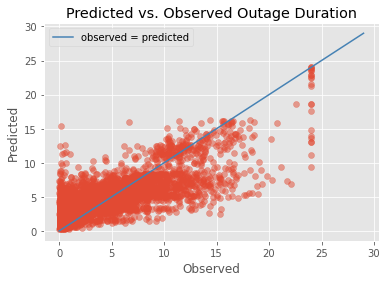

In [35]:
plt.scatter(y_test_m2, y_pred_m2, alpha = 0.5)
x = np.arange(0, 30)
plt.plot(x, x, label = 'observed = predicted', color = 'steelblue')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Predicted vs. Observed Outage Duration')
plt.legend()
plt.show()

In [36]:
tree = rf_tree
# YOUR CODE HERE
feature_importance = tree.feature_importances_ # get the importance of each feature

#calculate the relative feature importances 
relative_importance = feature_importance/np.max(feature_importance)

# Save to a dataframe with two columns: One holding the names of the features, 
# and one holding the associated relative importance of each feature.
feat_df = pd.DataFrame({'feature':X_train_m2.columns, 'importance':feature_importance})

feat_df.sort_values(by='importance', ascending=False).head(10)

,feature,importance
31,hr0,0.196870
0,Load Loss (MW),0.140449
3,distances_pp,0.073319
2,distances_trs,0.064885
1,Event No,0.041709
11,33KV,0.033988
10,11KV,0.029073
260,relativehumidity (-),0.018150
54,hr23,0.017980
265,Peak Generation (MW),0.016358
